# PHD bootstrap parameters analysis: prediction method

Given a sample of particles after clustering, we predict the position by taking the clusters centeroids. We could also take the particle with the heighest weight. These two methods are compared in this notebook. We can pass the argument 
`prediction_method` to the PHD object's method `predict` to specify:
- prediction_method = 'centers'
- prediction_method = 'max'

In [192]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from time import time
import imp, pickle 
import base, main, parameters
from collections import OrderedDict

imp.reload(main)
imp.reload(parameters)
imp.reload(base)
%matplotlib inline


##### import PHD objects

In [193]:
from main import PHD, PHD_bootstrap

##### import gaussian densities f, f_pdf, g, g_pdf and their constants 

In [194]:
from parameters import*

### 1 - Generate "nice" data:  I use previously saved data

Here I look for a good set of paths and save the object in the hardrive using pickle. I can simply load it from the saved file. DON'T SET generate to 1 unless you want to change the data ! 

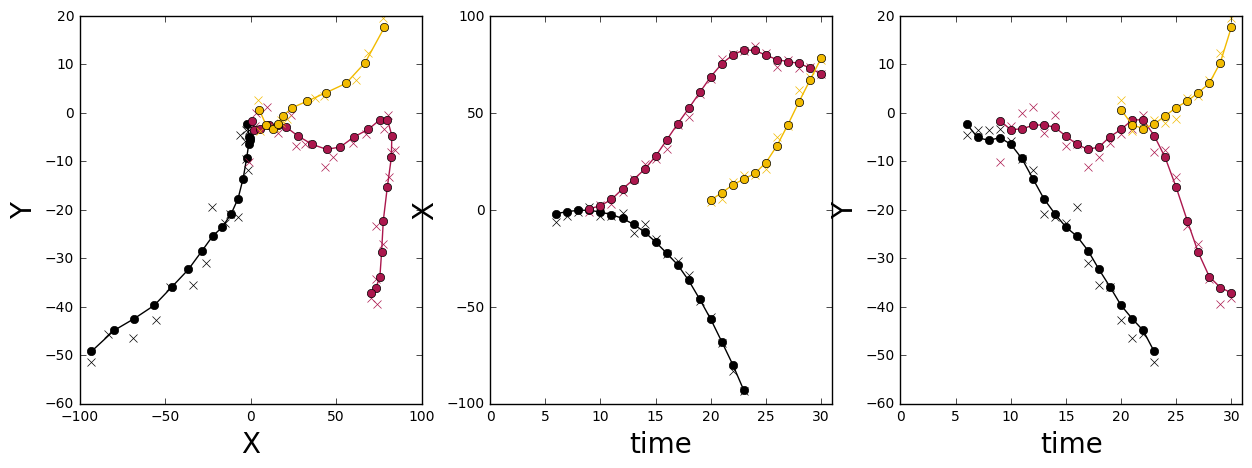

In [92]:
generate = 0
if generate: 
    generator = PHD(f=f, f_pdf=f_pdf, g=g, g_pdf=g_pdf, e=0.99, r=0, poisson_coef = 0.05, n_time_steps = 30)
    generator.generate()
    generator.plot_true()
    
    with open('generator','wb') as file:
        mypickler = pickle.Pickler(file)
        mypickler.dump(generator)
        
with open('generator','rb') as file:
    myreader = pickle.Unpickler(file)
    generator = myreader.load()

generator.plot_true()

# EXAMPLE: comparison centers vs max_weight: 

I have generated the data (stored in the generator object above), now I create two PHDs:
- prediction_method = centers
- prediction_method = max_weight

The first one uses kmeans centeroids as state estimates, the second one looks for the particle with the maximum weight, both among the resampled particles.

I keep track of the ospa distance and targets number estimation.

### 1- Centers method 

Total clutter is 10


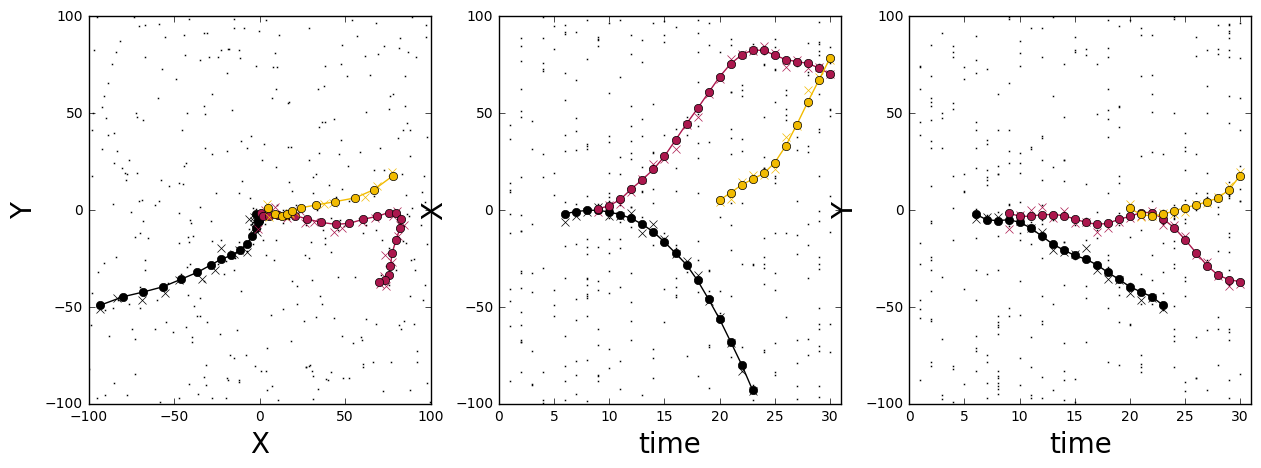

In [93]:
phd_centers = PHD_bootstrap(f=f, f_pdf=f_pdf, g=g, g_pdf=g_pdf)
phd_centers.set_generated_data(generator)
phd_centers.add_clutter(r=10)
phd_centers.plot_true(with_clutter=True)

I launch one prediction to see how much time it takes:

Time of one prediction:  10.759891033172607


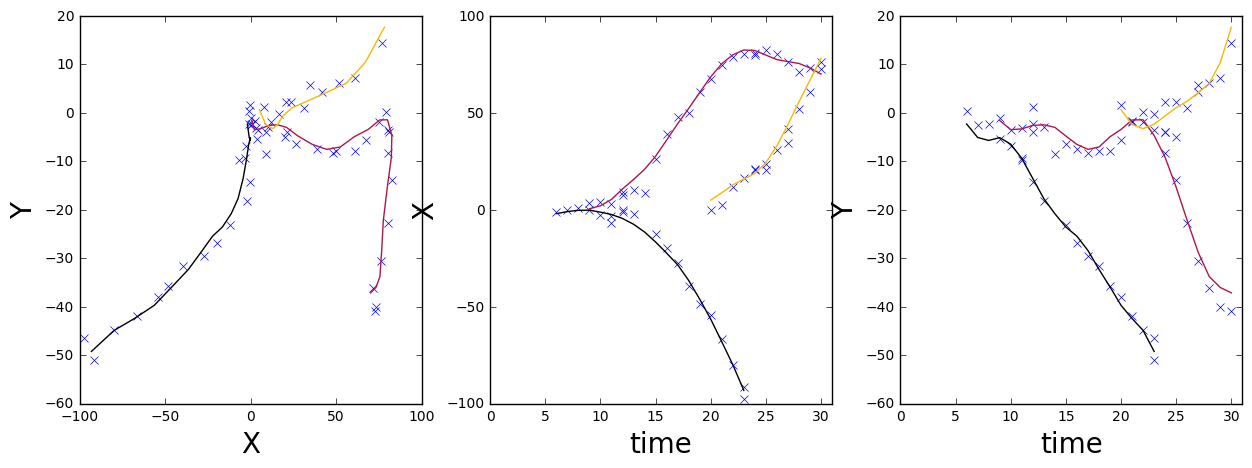

In [94]:
t = time()
phd_centers.predict(rho = 200, J = 50, n_jobs = -1, prediction_method='centers')
t = time()-t 
print("Time of one prediction: ",t)
phd_centers.plot_true_predictions()

Around 10 seconds, let's run 50 predictions and average them: 

In [101]:
n_size = 50
t = time()
ospa_centers, true_number, estimated_number = phd_centers.performance(rho = 200, J=50,n_jobs=-1, n_size= n_size,
                                                              prediction_method='centers',keep_n_targets=True)
t = time() - t 
print('Time of {} predictions: '.format(n_size), t)

Time of 50 predictions:  599.4156260490417


### 2 - max method
We create a second phd object and give it the same data and add clutter.

Total clutter is 10


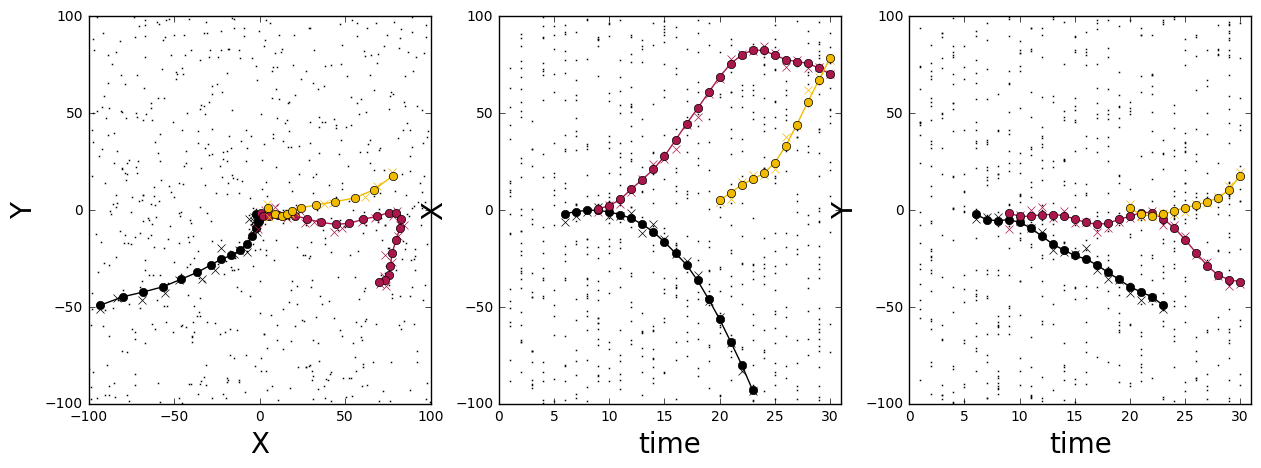

In [104]:
phd_max = PHD_bootstrap(f=f, f_pdf=f_pdf, g=g, g_pdf=g_pdf)
phd_max.set_generated_data(generator)
phd_max.add_clutter(r=10)
phd_max.plot_true(with_clutter=True)

In [105]:
n_size = 50
t = time()
ospa_max, true_max, estimated_max = phd_max.performance(rho = 200, J=50,n_jobs=-1, n_size= n_size,
                                                              prediction_method='max',keep_n_targets=True)
t = time() - t 

print('Time of {} predictions: '.format(n_size), t)

Time of 50 predictions:  802.2075169086456


## And we plot the comparison: 

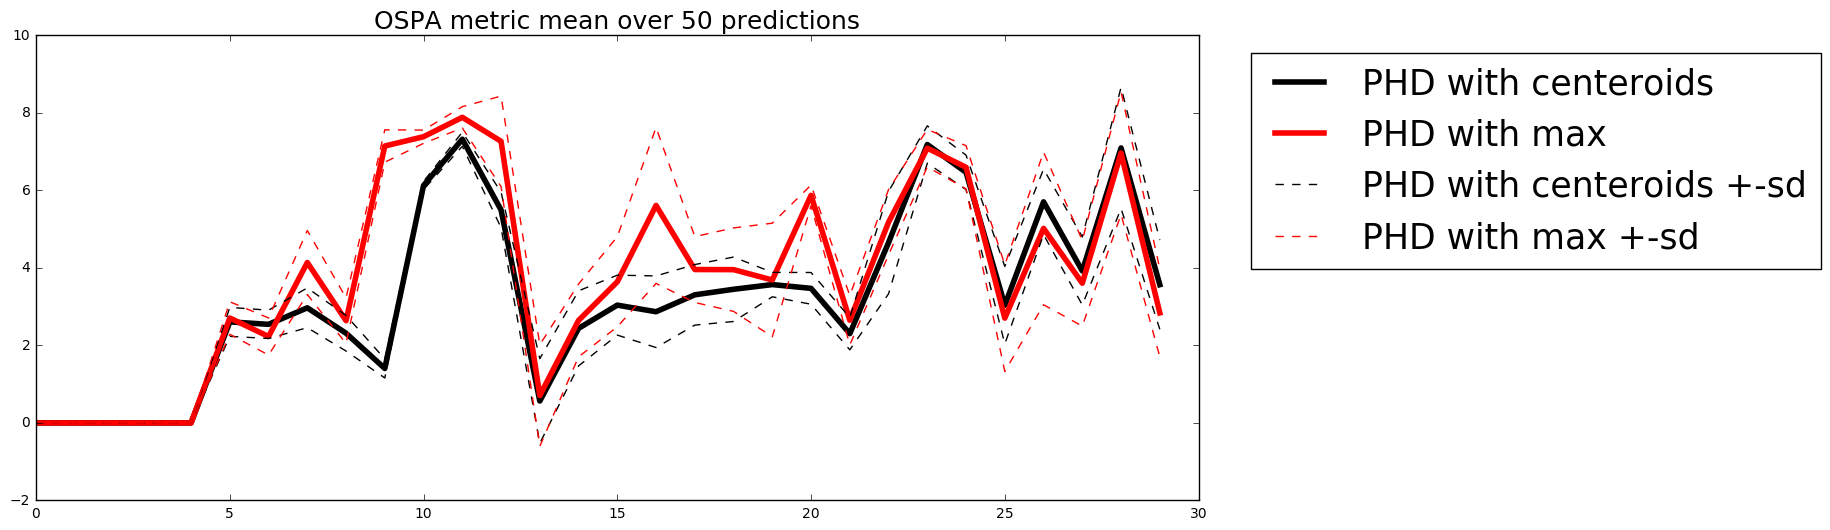

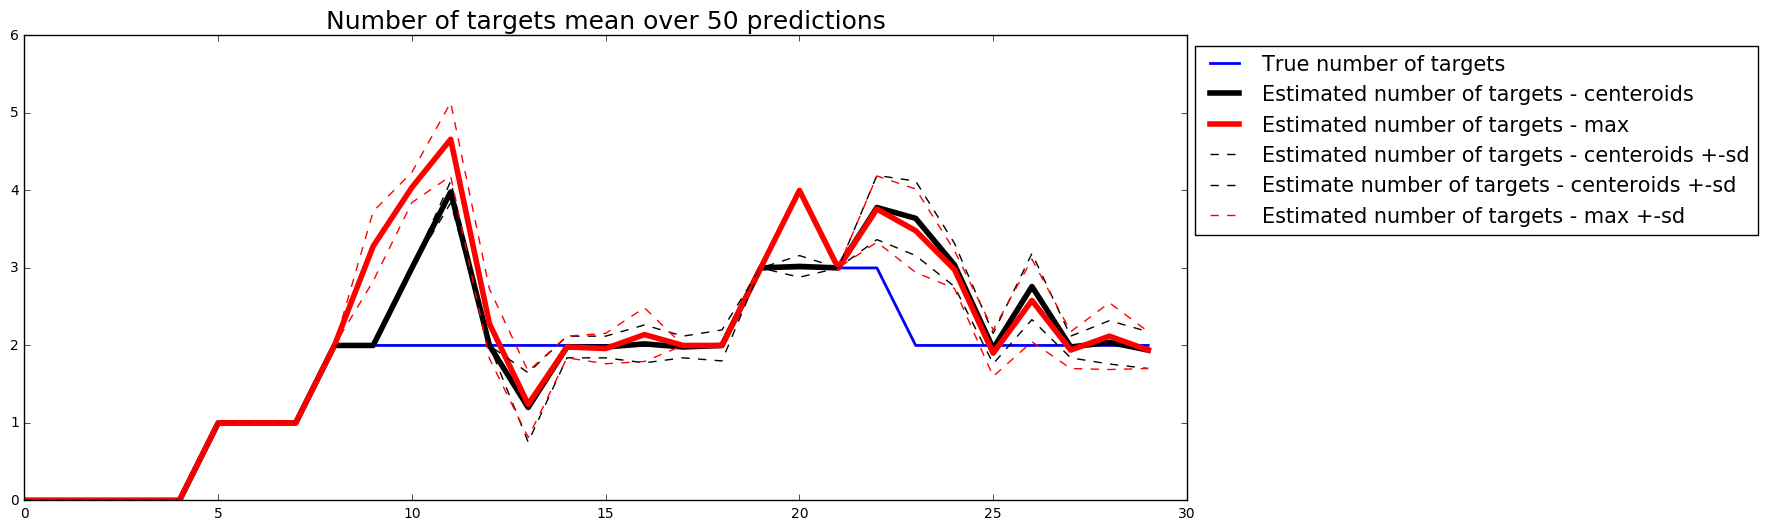

In [201]:
#OSPA
plt.figure(figsize=(15,6))

plt.plot(ospa_centers.mean(axis=0), c='k', label='PHD with centeroids', linewidth=4)
plt.plot(ospa_max.mean(axis=0), c='r', label='PHD with max', linewidth=4)

plt.plot(ospa_centers.mean(axis=0) + ospa_centers.std(axis=0), '--k', label='PHD with centeroids +-sd')
plt.plot(ospa_centers.mean(axis=0) - ospa_centers.std(axis=0), '--k', label='PHD with centeroids +-sd')

plt.plot(ospa_max.mean(axis=0) + ospa_max.std(axis=0), '--r', label='PHD with max +-sd')
plt.plot(ospa_max.mean(axis=0) - ospa_max.std(axis=0), '--r', label='PHD with max +-sd')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.title('OSPA metric mean over 50 predictions', fontsize=18)

plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor = [1.55,1], fontsize = 25);

#Number of Targets
plt.figure(figsize=(15,6))

plt.plot(true_max[0], 'b', linewidth=2, label="True number of targets")

plt.plot(estimated_number.mean(axis=0), c='k', label="Estimated number of targets - centeroids", linewidth=4)
plt.plot(estimated_max.mean(axis=0), c='r', label="Estimated number of targets - max", linewidth=4)

plt.plot(estimated_number.mean(axis=0) + estimated_number.std(axis=0), '--k', label="Estimated number of targets - centeroids +-sd")
plt.plot(estimated_number.mean(axis=0) - estimated_number.std(axis=0), '--k', label="Estimate number of targets - centeroids +-sd")

plt.plot(estimated_max.mean(axis=0) + estimated_max.std(axis=0), '--r', label="Estimated number of targets - max +-sd")
plt.plot(estimated_max.mean(axis=0) - estimated_max.std(axis=0), '--r', label="Estimated number of targets - max +-sd")


plt.title('Number of targets mean over 50 predictions', fontsize=18)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor = [1.5,1], fontsize=15)
plt.show();